2022暑期学校，机器视觉大作业：猫狗分类。

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt



from model import ResNeXt
from model import ResNet



In [ ]:


resnet = ResNet.resnet18



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 3, 224, 224])


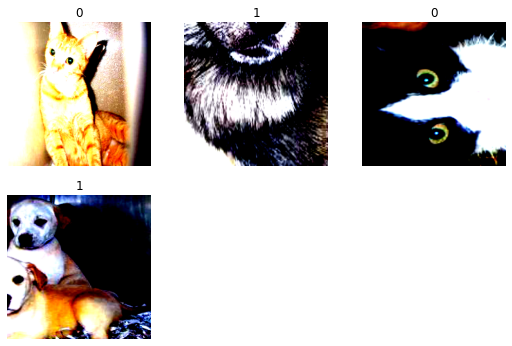

In [3]:
BATCH_SIZE=4
EPOCH=50
lr=0.0001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

valid_transform=transforms.Compose([
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
test_transform=transforms.Compose([
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
train_dataset =torchvision.datasets.ImageFolder(root='./dataset/train/',transform=train_transform)
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE, shuffle=True,num_workers=0)

val_dataset = torchvision.datasets.ImageFolder(root='./dataset/val/',transform=valid_transform)
val_loader = DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=True, num_workers=0)

test_dataset = torchvision.datasets.ImageFolder(root='./dataset/test/',transform=test_transform)
test_loader = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=True, num_workers=0)

images, labels = next(iter(train_loader))
print(images.size())  # torch.Size([9, 1, 28, 28])
#plt.figure(figsize=(9, 9))
plt.figure(figsize=(9,9))
for i in range(4):
    plt.subplot(3, 3, i+1)
    plt.title(labels[i].item())
    plt.imshow(images[i].permute(1, 2, 0), cmap='gray')
    plt.axis('off')
plt.show()



This code block is the train function and evaluate function

In [4]:
def evaluate_accuracy(data_iter, net,epoch, device=None):
    if device is None and isinstance(net, torch.nn.Module):
        # 如果没指定device就使用net的device
        device = list(net.parameters())[0].device
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            net.eval() # 评估模式, 这会关闭dropout
            acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
            net.train() # 改回训练模式
            n += y.shape[0]
    if acc_sum / n > 0.9:
        torch.save(net,'./trained_model/epoch %d acc %.3f.pth'% ((epoch+1),(acc_sum / n)))
    return acc_sum / n 

def train(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs):
    net = net.cuda()
    print("training on ", device)
    Loss_list = []
    Accuracy_train_list = []
    Accuracy_test_list = []

    loss = torch.nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, batch_count, start = 0.0, 0.0, 0, 0, time.time()
        for X, y in train_iter:
            X = X.cuda()
            y = y.cuda()
            y_hat = net(X)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
        test_acc = evaluate_accuracy(test_iter, net,epoch)
        Loss_list.append(train_l_sum / batch_count)
        Accuracy_train_list.append(100 *(train_acc_sum / n))
        Accuracy_test_list.append(100*test_acc)

        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))
    
    x1 = range(0,EPOCH)
    
    plt.subplot(1,3,1)
    plt.plot(x1,Loss_list)
    plt.legend(['train_loss'])
    plt.subplot(1,3,2)
    plt.plot(x1,Accuracy_train_list)
    plt.legend(['train_acc'])
    plt.subplot(1,3,3)
    plt.plot(x1,Accuracy_test_list)
    plt.legend(['test_acc'])
    #plt.legend(['train_loss','train_acc','test_loss'])
    
    plt.show()


training on  cuda
epoch 1, loss 0.6484, train acc 0.621, test acc 0.663, time 285.7 sec
epoch 2, loss 0.5410, train acc 0.722, test acc 0.794, time 180.7 sec
epoch 3, loss 0.4713, train acc 0.768, test acc 0.820, time 177.7 sec
epoch 4, loss 0.4233, train acc 0.795, test acc 0.852, time 176.9 sec
epoch 5, loss 0.3798, train acc 0.823, test acc 0.853, time 173.2 sec
epoch 6, loss 0.3505, train acc 0.835, test acc 0.880, time 171.5 sec
epoch 7, loss 0.3235, train acc 0.851, test acc 0.849, time 168.0 sec
epoch 8, loss 0.3039, train acc 0.861, test acc 0.891, time 174.4 sec
epoch 9, loss 0.2958, train acc 0.864, test acc 0.906, time 174.7 sec
epoch 10, loss 0.2855, train acc 0.870, test acc 0.908, time 173.9 sec
epoch 11, loss 0.2690, train acc 0.877, test acc 0.902, time 176.9 sec
epoch 12, loss 0.2604, train acc 0.880, test acc 0.913, time 176.4 sec
epoch 13, loss 0.2491, train acc 0.888, test acc 0.922, time 174.5 sec
epoch 14, loss 0.2424, train acc 0.890, test acc 0.919, time 184.7 s

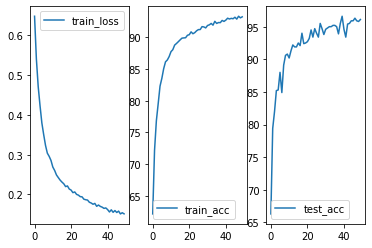

In [5]:
optimizer = torch.optim.Adam(ResNet.resnet18.parameters(), lr=lr)

train(ResNet.resnet18,train_loader,test_loader,BATCH_SIZE,optimizer,device,EPOCH)

Below is the test block

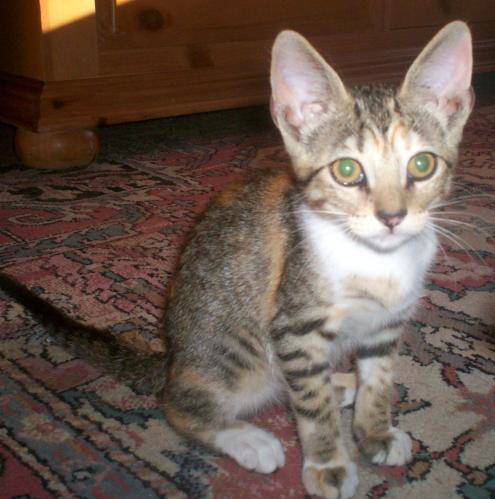

Predict label: cat


In [12]:
from torchvision import transforms
from torch.autograd import Variable
from PIL import Image

transform = transforms.Compose([
            #transforms.Scale(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

idx_to_class = {0:'cat', 1:'dog'}

inference_model=torch.load('./trained_model/ResNet18.pth')
#inference_model=torch.load('./trained_model/Swin_T.pth')

def predict(use_cuda, model, image_name):
    test_image = Image.open(image_name)
    test_image_tensor = transform(test_image)
    if use_cuda:
        model.cuda()
        test_image_tensor = test_image_tensor.cuda()
        #print('all on cuda')
    else:
        test_image_tensor = test_image_tensor
    test_image_tensor = Variable(torch.unsqueeze(test_image_tensor, dim=0).float(), requires_grad=False)

    with torch.no_grad():
        model.eval()
        #print(model)
        out = model(test_image_tensor)
        ps = torch.exp(out)  #Softmax操作，转换成概率分布
        ps = ps / torch.sum(ps)
        topk, topclass = ps.topk(1, dim=1)
        return(idx_to_class[topclass.cpu().numpy()[0][0]], topk.cpu().numpy()[0][0])

image_path = './dataset/test/cat/cat.7.jpg'
img=Image.open(image_path)
display(img)
print('Predict label:',predict(1,inference_model,image_path)[0])
